In [1]:

import sys
sys.path.append("../")

import matplotlib.pyplot as plt 
import torchvision.transforms as T
from src.class_activation_map import class_activation_map, gradient_class_activation_map
from src.utils import get_cifar10_dataloader
import torchvision.transforms as T # Transformation functions to manipulate images

device = "cuda"
# device = "cpu"

trainDataLoader, testDataLoader = get_cifar10_dataloader(transforms=T.Compose([T.ToTensor()]))

/home/bumjin/anaconda3/envs/deeping/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[+] Get the MNIST DATA
Files already downloaded and verified
Files already downloaded and verified
[+] Finished loading data & Preprocessing


In [4]:
import torch 
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, model="linear"):
        super().__init__()
        self.model_type = model
        if model =="linear":
            self.linear1 = nn.Linear(784, 128)
            self.linear2 = nn.Linear(128, 10)
        elif model == "cnn":
            self.conv1 = nn.Conv2d(in_channels= 3, out_channels=32, kernel_size=3, stride=1)	
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
            self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
            self.fc1 = nn.Linear(in_features=128, out_features=10, bias=False)
            
    def forward(self, x):
        batch_size = x.size(0)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        last_convolution_features = x
        F_k = torch.nn.functional.adaptive_avg_pool2d(last_convolution_features, (1,1)).view(batch_size, -1)
        x =  nn.functional.relu(self.fc1(F_k))
        return x 

    def forward_for_cam(self, x):
        batch_size = x.size(0)
        assert batch_size == 1
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        last_convolution_features = x
        F_k = torch.nn.functional.adaptive_avg_pool2d(last_convolution_features, (1,1)).view(batch_size, -1)
        x =  nn.functional.relu(self.fc1(F_k))
        _class = x.argmax(axis=-1).item()
        return x, last_convolution_features, self.fc1.weight[_class, :]

cnn_model = Model(model="cnn").to(device=device)

In [33]:
from torch.autograd import Variable


def train(net, train_loader, optimizer, criterion,  epoch=2):
    net.train()
    for e in range(epoch):
        running_loss = 0.0  
        for i, data in enumerate(train_loader, 0): 
            # get the inputs
            inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
            inputs = Variable(inputs).to(device=device)
            labels = Variable(labels).to(device=device)
            # zero the parameter gradients
            optimizer.zero_grad()    

            # forward + backward + optimize
            outputs = net(inputs) # get output after passing through the network
            loss = criterion(outputs, labels) # compute model's score using the loss function 
            loss.backward() # perform back-propagation from the loss
            optimizer.step() # perform gradient descent with given optimizer

            # print statistics
            running_loss += loss.item()
            if (i+1) % 500 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                running_loss = 0.0

criterion = nn.CrossEntropyLoss() 
models = [cnn_model]
optimizers  = [torch.optim.Adam(cnn_model.parameters(), lr=0.001, )]


for model, opti, in zip(models, optimizers):
    print("--- Training Started with model ---")
    print(model)
    train(model, trainDataLoader, opti, criterion, 3)


--- Training Started with model ---
Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=False)
)
[1,   500] loss: 2.090
[1,  1000] loss: 2.086
[1,  1500] loss: 2.069
[2,   500] loss: 2.077
[2,  1000] loss: 2.064
[2,  1500] loss: 2.045
[3,   500] loss: 2.041
[3,  1000] loss: 2.052
[3,  1500] loss: 2.038


In [42]:

x = trainDataLoader.dataset[4][0].cuda().clone().unsqueeze(0)
print(x.size())
model = models[0]

output, last_conv_feature, last_weights = model.forward_for_cam(x)
last_weights = last_weights.squeeze(0)

last_conv_feature = last_conv_feature.clone()
print(last_conv_feature.size(), last_weights.size())
cam = class_activation_map(last_conv_feature, last_weights)
grad_cam = gradient_class_activation_map(last_conv_feature, last_weights)

index = cam['class_activation_map'][:-1].argmax(axis=-1)
print(index.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 128, 26, 26]) torch.Size([128])
tensor([2.3827], device='cuda:0', grad_fn=<MvBackward0>)
torch.Size([0, 26])


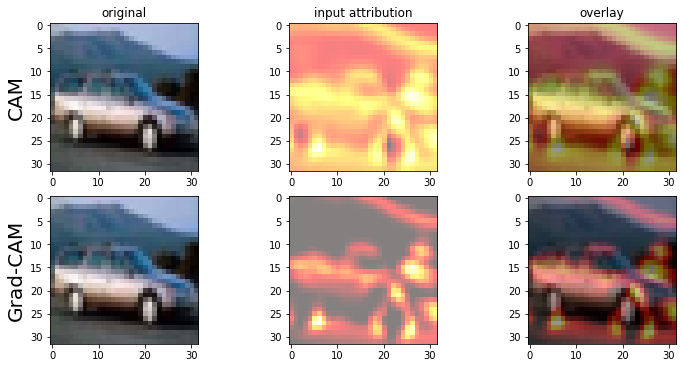

In [48]:
import matplotlib.pyplot as plt 
import torchvision.transforms as T

upsampled = cam['class_activation_map']
upsampled = T.Resize(x.size(2), T.InterpolationMode.BILINEAR)(upsampled)

upsampled_grad = grad_cam['class_activation_map']
upsampled_grad = T.Resize(x.size(2), T.InterpolationMode.BILINEAR)(upsampled_grad)
fig, ax = plt.subplots(2, 3, constrained_layout=True, figsize=(10,5))


for i, (input_attribution, name) in enumerate(zip([upsampled, upsampled_grad], ["CAM" , "Grad-CAM"])):
    input = x.squeeze(0).detach().cpu().permute(1,2,0).numpy()
    input_attribution = input_attribution.detach().cpu().permute(1,2,0).numpy()
    ax[i][0].imshow(input, cmap='binary')
    ax[i][1].imshow(input_attribution, alpha=0.5, cmap='hot')
    ax[i][2].imshow(input, cmap='binary', alpha=1)
    ax[i][2].imshow(input_attribution, cmap='hot', alpha=0.4)
    ax[i][0].set_ylabel(name, fontsize=20)

ax[0][0].set_title("original")
ax[0][1].set_title("input attribution")
ax[0][2].set_title("overlay")
plt.show()

